# LOGISTIC REGRESSION

## Imports

In [6]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Import Dataset

In [7]:
DATASET_PATH = "../data/output/tfidf_dataset.csv"
RNG = 42  # Random seed
TEST_SIZE = 0.2

df = pd.read_csv(DATASET_PATH)

print(df['cyberbullying'].value_counts())
df.head(10)

cyberbullying
0    16225
1    16225
Name: count, dtype: int64


,10th,12th,15th,16th,1960s,19th,19th century,1px,1px solid,1st,...,zealand,zero,zionist,zoe,zone,zoo,zuck,zuckerberg,ŷour,cyberbullying
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Fitting

In [8]:
# 1. Separate features and labels
X = df.drop(columns=['cyberbullying'])  # TF-IDF features
y = df['cyberbullying']                 # Target label

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RNG, stratify=y
)

# 3. Initialize model and parameter grid (varying C)
log_reg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",   # auto-weight classes inversely to their frequency to avoid imbalance
    solver="liblinear"         # supports L1 & L2
)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "penalty": ["l2", "l1"],   # Try both L2 & L1
}

# 4. Set up cross-validation strategy (5-fold for acceptable bias-variance tradeoff)
# Specifically, evaluate on out of fold predictions (Just one prediction per sample, 
# made by a model trained samples from all other folds.)
K = 5 # Number of folds for k-fold CV
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=RNG)

# 5. Run grid search to determine the best value for C
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1_macro',  # Choose 'f1_macro' for balanced class evaluation
    cv=cv,
    n_jobs=1       
)
grid_search.fit(X_train, y_train)

# 6. Retrieve and display the best model
best_model = grid_search.best_estimator_
print(f"Best C value: {grid_search.best_params_['C']}")
print(f"Best F1 (macro): {grid_search.best_score_:.4f}")
print()

# 6. Predict on the full data using the best model
y_pred = best_model.predict(X_test)

Best C value: 10
Best F1 (macro): 0.8915




Classification Report:
                   precision    recall  f1-score   support

Not Cyberbullying       0.88      0.91      0.89      3245
    Cyberbullying       0.91      0.87      0.89      3245

         accuracy                           0.89      6490
        macro avg       0.89      0.89      0.89      6490
     weighted avg       0.89      0.89      0.89      6490



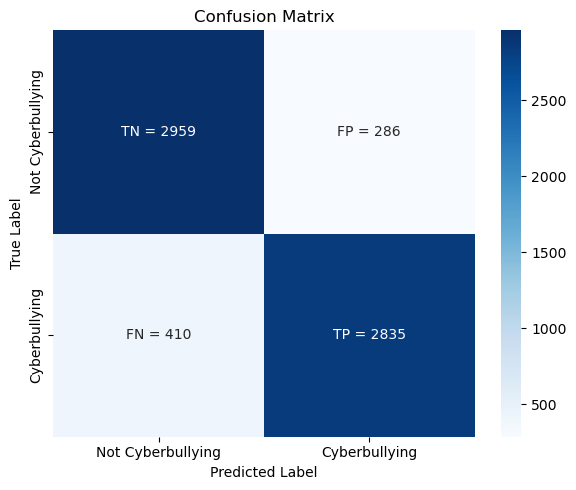

In [9]:
# 7. Display performance metrics

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['Not Cyberbullying', 'Cyberbullying']
))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Cyberbullying', 'Cyberbullying']

# Annotate with TP, TN, FP, FN
annot_labels = [
    [f"TN = {cm[0,0]}", f"FP = {cm[0,1]}"],
    [f"FN = {cm[1,0]}", f"TP = {cm[1,1]}"]
]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Axis labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## Feature Extraction and Visualization

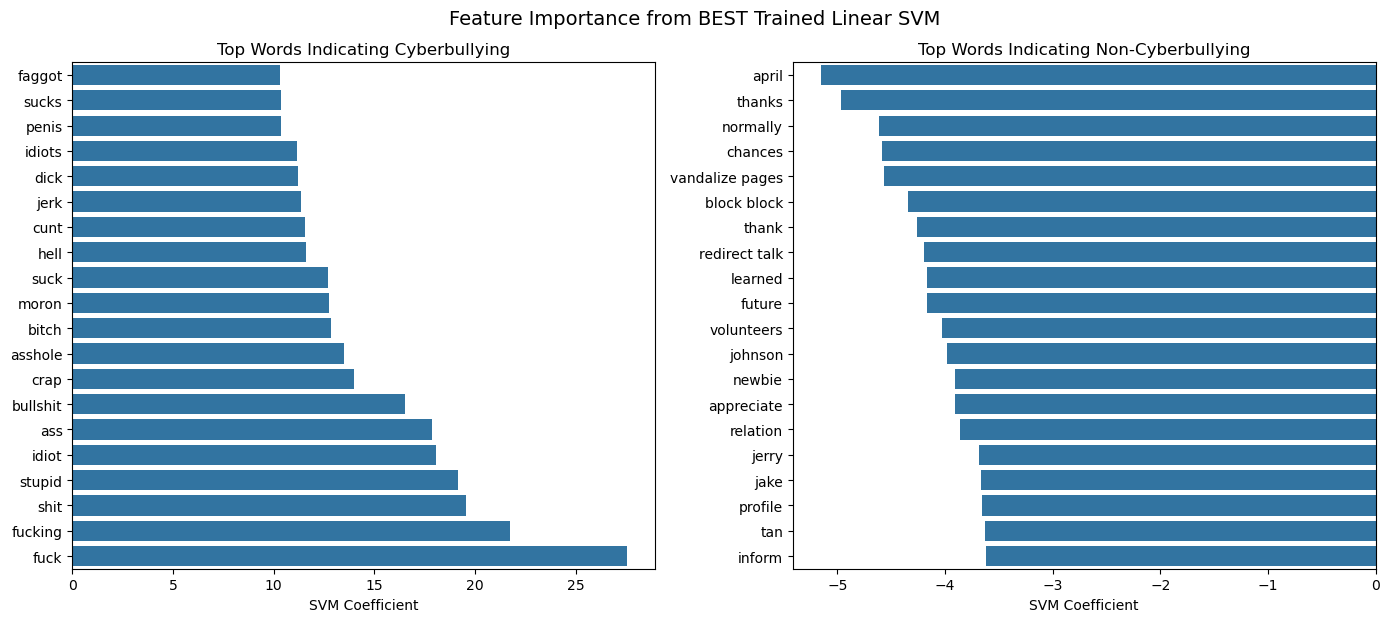

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract coefficients
coefs = best_model.coef_.flatten()
feature_names = X.columns.to_numpy()

# Identify top features for both classes
top_n = 20
top_pos_idx = np.argsort(coefs)[-top_n:]
top_neg_idx = np.argsort(coefs)[:top_n]

# Plot
plt.figure(figsize=(14, 6))

# Top features indicating cyberbullying (positive class)
plt.subplot(1, 2, 1)
sns.barplot(x=coefs[top_pos_idx], y=feature_names[top_pos_idx])
plt.title("Top Words Indicating Cyberbullying")
plt.xlabel("SVM Coefficient")
plt.tight_layout()

# Top features indicating non-cyberbullying (negative class)
plt.subplot(1, 2, 2)
sns.barplot(x=coefs[top_neg_idx], y=feature_names[top_neg_idx])
plt.title("Top Words Indicating Non-Cyberbullying")
plt.xlabel("SVM Coefficient")
plt.tight_layout()

plt.suptitle("Feature Importance from BEST Trained Linear SVM", fontsize=14, y=1.03)
plt.show()